In [68]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Load Data

Data is prepared by the authors of [this](https://arxiv.org/pdf/2307.16336.pdf) paper and is provided [here](https://www.dropbox.com/scl/fo/l49jls7vvz4tgbnv9drnf/h?rlkey=yu44uqhziglxzsjkc5l7cu0uh&dl=0).

In [69]:
df = pd.read_json('./data/fox8_23_dataset.ndjson', lines=True)
df.head()

,user_id,label,dataset,user_tweets
0,16905397,human,botometer-feedback,"[{'contributors': None, 'truncated': True, 'te..."
1,2717053344,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."
2,297051227,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."
3,282275320,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."
4,1663020151,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."


The format of the data is described [here](https://github.com/osome-iu/AIBot_fox8) where the `user_tweets` column contains tweet objects that follow [this](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet) schema.

In [70]:
df_exploded = df.explode('user_tweets')
df_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368028 entries, 0 to 2279
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      368028 non-null  int64 
 1   label        368028 non-null  object
 2   dataset      368028 non-null  object
 3   user_tweets  368028 non-null  object
dtypes: int64(1), object(3)
memory usage: 14.0+ MB


# Explode Data

In [71]:
rel_tweet_fields = ['created_at', 'text', 'id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'is_quote_status']

df_exploded['user_tweets'] = df_exploded['user_tweets'].map(lambda tweet: {field: tweet[field] for field in rel_tweet_fields})
df_user_tweets_exploded = df_exploded['user_tweets'].apply(pd.Series)

df_full_exploded = pd.concat([df_exploded, df_user_tweets_exploded], axis=1).drop('user_tweets', axis=1)
df_full_exploded.head()

# EDA

Understand difference in # of tweets between bots and humans.

In [ ]:
num_tweets = df_full_exploded.groupby(['label', 'user_id'])['text'].count().to_frame().reset_index()
fig = px.violin(num_tweets, y="label", x="text", box=True, points='all')
fig.update_layout(xaxis_title='# Tweets', yaxis_title='Source')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'box': {'visible': True},
              'hovertemplate': 'text=%{x}<br>label=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa'},
              'name': '',
              'offsetgroup': '',
              'orientation': 'h',
              'points': 'all',
              'scalegroup': 'True',
              'showlegend': False,
              'type': 'violin',
              'x': array([145, 149, 120, ...,  58,   4,   1]),
              'x0': ' ',
              'xaxis': 'x',
              'y': array(['bot', 'bot', 'bot', ..., 'human', 'human', 'human'], dtype=object),
              'y0': ' ',
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'violinmode': 'group',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': '# Tweets'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Source'}}}
})

Understand difference in # of likes between bots and humans.

In [ ]:
num_favs = df_full_exploded.groupby(['label', 'user_id'])['favorite_count'].sum().to_frame().reset_index()
fig = px.violin(num_favs, y="label", x="favorite_count", box=True, points="all")
fig.update_layout(xaxis_title='# Likes', yaxis_title='Source')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'box': {'visible': True},
              'hovertemplate': 'favorite_count=%{x}<br>label=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa'},
              'name': '',
              'offsetgroup': '',
              'orientation': 'h',
              'points': 'all',
              'scalegroup': 'True',
              'showlegend': False,
              'type': 'violin',
              'x': array([28, 17, 17, ...,  3,  2, 10]),
              'x0': ' ',
              'xaxis': 'x',
              'y': array(['bot', 'bot', 'bot', ..., 'human', 'human', 'human'], dtype=object),
              'y0': ' ',
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'violinmode': 'group',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': '# Likes'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Source'}}}
})

Build graph user interactions. View the graph on [CosmoGraph](https://cosmograph.app/).

In [20]:
user_interaction_edge_list = df_full_exploded.groupby(['user_id', 'in_reply_to_user_id'])['text'].count().to_frame().reset_index()
user_interaction_edge_list['in_reply_to_user_id'] = user_interaction_edge_list['in_reply_to_user_id'].astype(int)
user_interaction_edge_list = user_interaction_edge_list.rename(columns={'user_id': 'from', 'in_reply_to_user_id': 'to', 'text': 'num_replies'})
user_interaction_edge_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91689 entries, 0 to 91688
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   from         91689 non-null  int64
 1   to           91689 non-null  int64
 2   num_replies  91689 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB


In [53]:
user_list = df_full_exploded.groupby(['user_id', 'label']).agg({'text': 'count', 'retweet_count': 'sum', 'favorite_count': 'sum'}).reset_index()
user_list['user_id'] = user_list['user_id'].astype(int)
user_list['label'] = user_list['label'].map(lambda x: 1 if x == 'human' else 0).astype(int)
user_list = user_list.merge(pd.Series(user_interaction_edge_list['to'].unique()).to_frame(), left_on='user_id', right_on=0, how='outer').drop(0, axis=1)
user_list['label'] = user_list['label'].fillna(0.5)
user_list = user_list.rename(columns={'user_id': 'id'})
user_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48983 entries, 0 to 48982
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              48983 non-null  int64  
 1   label           48983 non-null  float64
 2   text            2279 non-null   float64
 3   retweet_count   2279 non-null   float64
 4   favorite_count  2279 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 1.9 MB


In [55]:
user_interaction_edge_list.to_csv('./data/user_edge_list.csv', index=False)
user_list.to_csv('./data/user_node_list.csv', index=False)

Understand common words used in bot tweets.

(-0.5, 799.5, 499.5, -0.5)

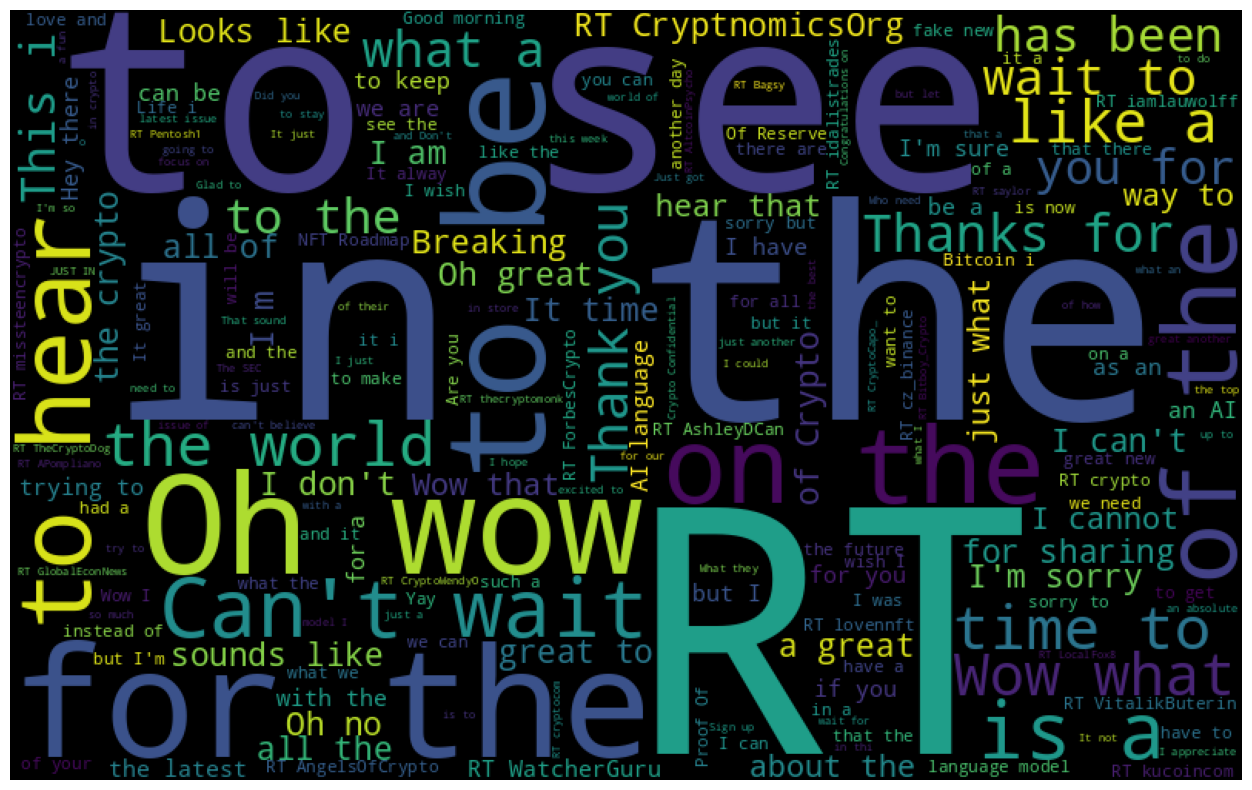

In [66]:
stopwords = STOPWORDS + ['https', 't', 'co', 'take', 'to', 'be', 'in', 'the', 'to see', 'in the', 'to be', 'to hear', 'for the']
wc = WordCloud(width=800, height=500, stopwords=stopwords)\
    .generate(' '.join(df_full_exploded.loc[df_full_exploded['label'] == 'bot', 'text'].values))
plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')

Understand common words in human tweets.

(-0.5, 799.5, 499.5, -0.5)

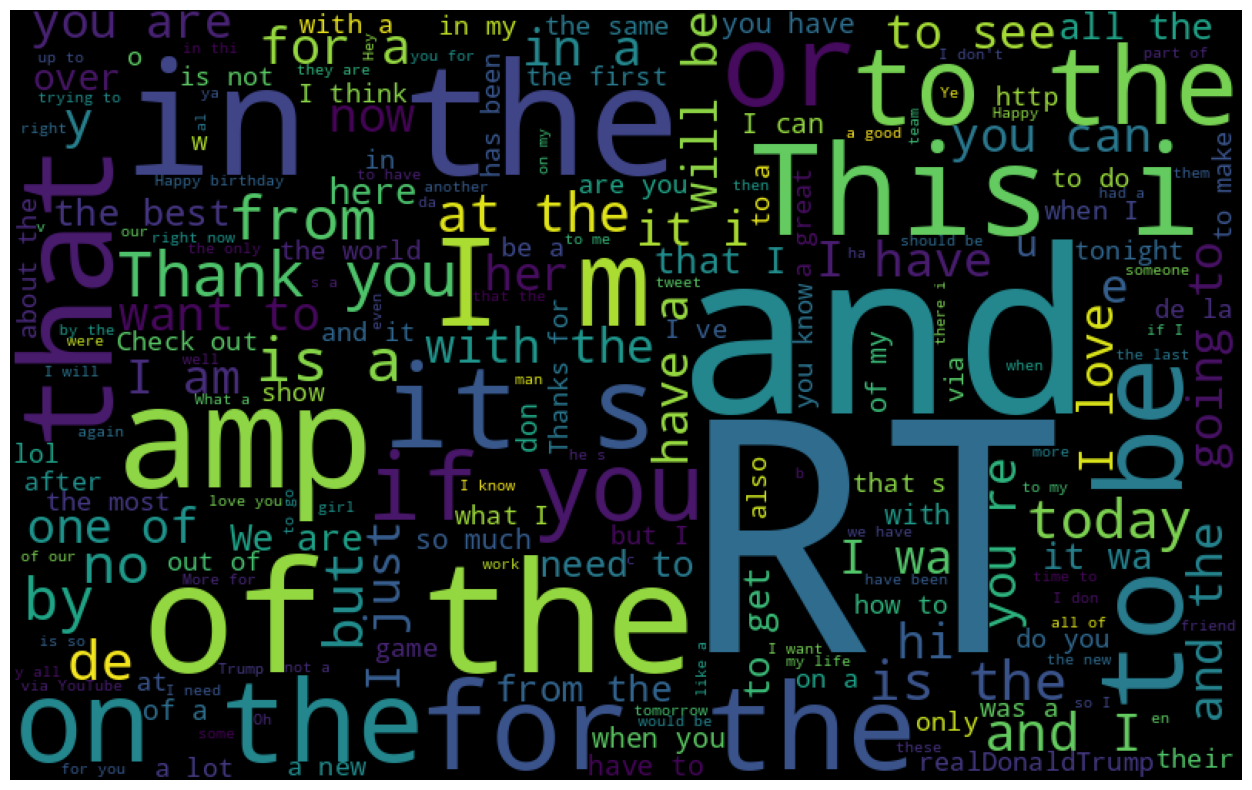

In [67]:
#stopwords = STOPWORDS + ['https', 't', 'co', 'take']
wc = WordCloud(width=800, height=500, stopwords=STOPWORDS)\
    .generate(' '.join(df_full_exploded.loc[df_full_exploded['label'] == 'human', 'text'].values))
plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')